In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import numpy as np
import random
from torch.utils.data import DataLoader, Subset
from torch.nn import AdaptiveAvgPool3d
import os
from tqdm import tqdm

# Reproducibility
torch.manual_seed(2)
np.random.seed(2)
random.seed(2)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loader

# Group Definition
class CyclicGroup:
    def __init__(self, order: int):
        self.n_int = order

    def elements(self, device=None):
        angles = [2 * np.pi * k / self.n_int for k in range(self.n_int)]
        return torch.tensor(angles, dtype=torch.float32, device=device)

    def product(self, h, h_prime):
        return torch.remainder(h + h_prime, 2 * np.pi)

    def inverse(self, h):
        return torch.remainder(-h, 2 * np.pi)

    def left_regular_representation(self, h, x):
        return torch.matmul(self.matrix_representation(h), x)

    def matrix_representation(self, h):
        return torch.tensor([
            [torch.cos(h), -torch.sin(h)],
            [torch.sin(h), torch.cos(h)]
        ], device=h.device)

# Kernel Rotation Helper
def rotate_kernel(kernel_2d, group, angle_rad):
    H, W = kernel_2d.shape
    device = kernel_2d.device
    y, x = torch.meshgrid(torch.linspace(-1, 1, H, device=device),
                          torch.linspace(-1, 1, W, device=device),
                          indexing='ij')
    grid = torch.stack([x, y], dim=-1).view(-1, 2)
    angle_inv = group.inverse(angle_rad)
    rot_grid_flat = torch.stack([group.left_regular_representation(angle_inv, coord) for coord in grid], dim=0)
    rot_grid = rot_grid_flat.view(H, W, 2).unsqueeze(0)
    kernel = kernel_2d.unsqueeze(0).unsqueeze(0)
    rotated = F.grid_sample(kernel, rot_grid, align_corners=True, mode='bilinear', padding_mode='zeros')
    return rotated.squeeze()

class LiftingConvolution(nn.Module):
    def __init__(self, group, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.group = group
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding

        # Base kernel is NOT shared across group elements (following 1:1 theory)
        self.base_kernel = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        nn.init.kaiming_uniform_(self.base_kernel, a=np.sqrt(5))

    def forward(self, x):
        device = x.device
        group_elements = self.group.elements(device=device)

        batch_size, _, height, width = x.shape
        outputs = []

        for g_idx, angle in enumerate(group_elements):
            rotated_kernel = torch.zeros_like(self.base_kernel)
            for oc in range(self.out_channels):
                for ic in range(self.in_channels):
                    rotated_kernel[oc, ic] = rotate_kernel(self.base_kernel[oc, ic], self.group, angle)

            conv_out = F.conv2d(x, rotated_kernel, padding=self.padding)  # shape: (B, out_channels, H, W)
            outputs.append(conv_out.unsqueeze(2))  # shape: (B, out_channels, 1, H, W)

        return torch.cat(outputs, dim=2)  # shape: (B, out_channels, G, H, W)
class GroupConvolution(nn.Module):
    def __init__(self, group, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.group = group
        self.G = group.n_int
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding

        # One kernel per (g_out, g_in)
        self.base_kernel = nn.Parameter(torch.randn(
            self.G, self.G, out_channels, in_channels, kernel_size, kernel_size
        ))
        nn.init.kaiming_uniform_(self.base_kernel, a=np.sqrt(5))

    def forward(self, x):
        # x shape: (B, C_in, G_in, H, W)
        B, C_in, G_in, H, W = x.shape
        device = x.device
        group_elements = self.group.elements(device=device)

        output = torch.zeros(B, self.out_channels, self.G, H, W, device=device)

        for g_out_idx, g_out in enumerate(group_elements):
            for g_in_idx, g_in in enumerate(group_elements):
                h_rel = self.group.product(self.group.inverse(g_out), g_in)

                for oc in range(self.out_channels):
                    for ic in range(C_in):
                        base_k = self.base_kernel[g_out_idx, g_in_idx, oc, ic]
                        rot_k = rotate_kernel(base_k, self.group, h_rel).unsqueeze(0).unsqueeze(0)
                        x_in = x[:, ic, g_in_idx].unsqueeze(1)  # shape: (B, 1, H, W)
                        conv_out = F.conv2d(x_in, rot_k, padding=self.padding)
                        output[:, oc, g_out_idx] += conv_out.squeeze(1)

        return output  # shape: (B, out_channels, G, H, W)



### LIFTING CONV

In [2]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import os

# Assuming your lifting conv and group are defined somewhere and imported
# from your_module import CyclicGroup, LiftingConvolution

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths (adjust as needed)
input_image_path = "/workspaces/G-CNN-P5/cancer.png"
output_dir = "./images"
os.makedirs(output_dir, exist_ok=True)

# Load input image grayscale and transform
image = Image.open(input_image_path).convert('L')
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),  # 1xHxW tensor
])
x = transform(image).unsqueeze(0).to(device)  # shape (1,1,H,W)

# Save grayscale input image for TikZ
image.save(os.path.join(output_dir, "grayscale_input.png"))

# Create group and lifting convolution layer
group = CyclicGroup(order=8)
lifting = LiftingConvolution(group, in_channels=1, out_channels=1, kernel_size=7, padding=3).to(device)

# Forward pass (eval mode)
lifting.eval()
with torch.no_grad():
    y = lifting(x)  # shape: (1, out_channels=1, group_order=8, H, W)
    y = y.squeeze(0).squeeze(0).cpu()  # shape: (8, H, W)

# Save base kernel image
base_kernel = lifting.base_kernel[0, 0].detach().cpu()
plt.imsave(os.path.join(output_dir, "base_kernel.png"), base_kernel.numpy(), cmap='gray')

# Save lifted feature maps
# ... (rest of the script unchanged)

# Save lifted feature maps (in grayscale)
for i in range(8):
    fmap = y[i].numpy()
    fmap_norm = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)
    plt.imsave(os.path.join(output_dir, f"feature_map_{i}.png"), fmap_norm, cmap='gray')

print(f"Saved input, kernel, and 8 lifted feature maps to '{output_dir}/'")




Saved input, kernel, and 8 lifted feature maps to './images/'


/pytorch/third_party/ideep/mkl-dnn/src/cpu/aarch64/xbyak_aarch64/src/util_impl_linux.h, 451: Can't read MIDR_EL1 sysfs entry


### GROUP CONV

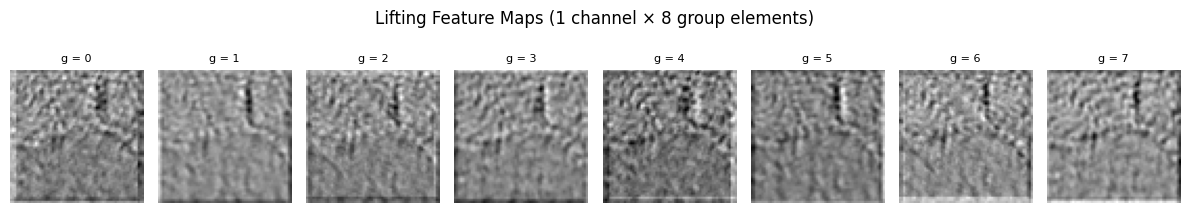

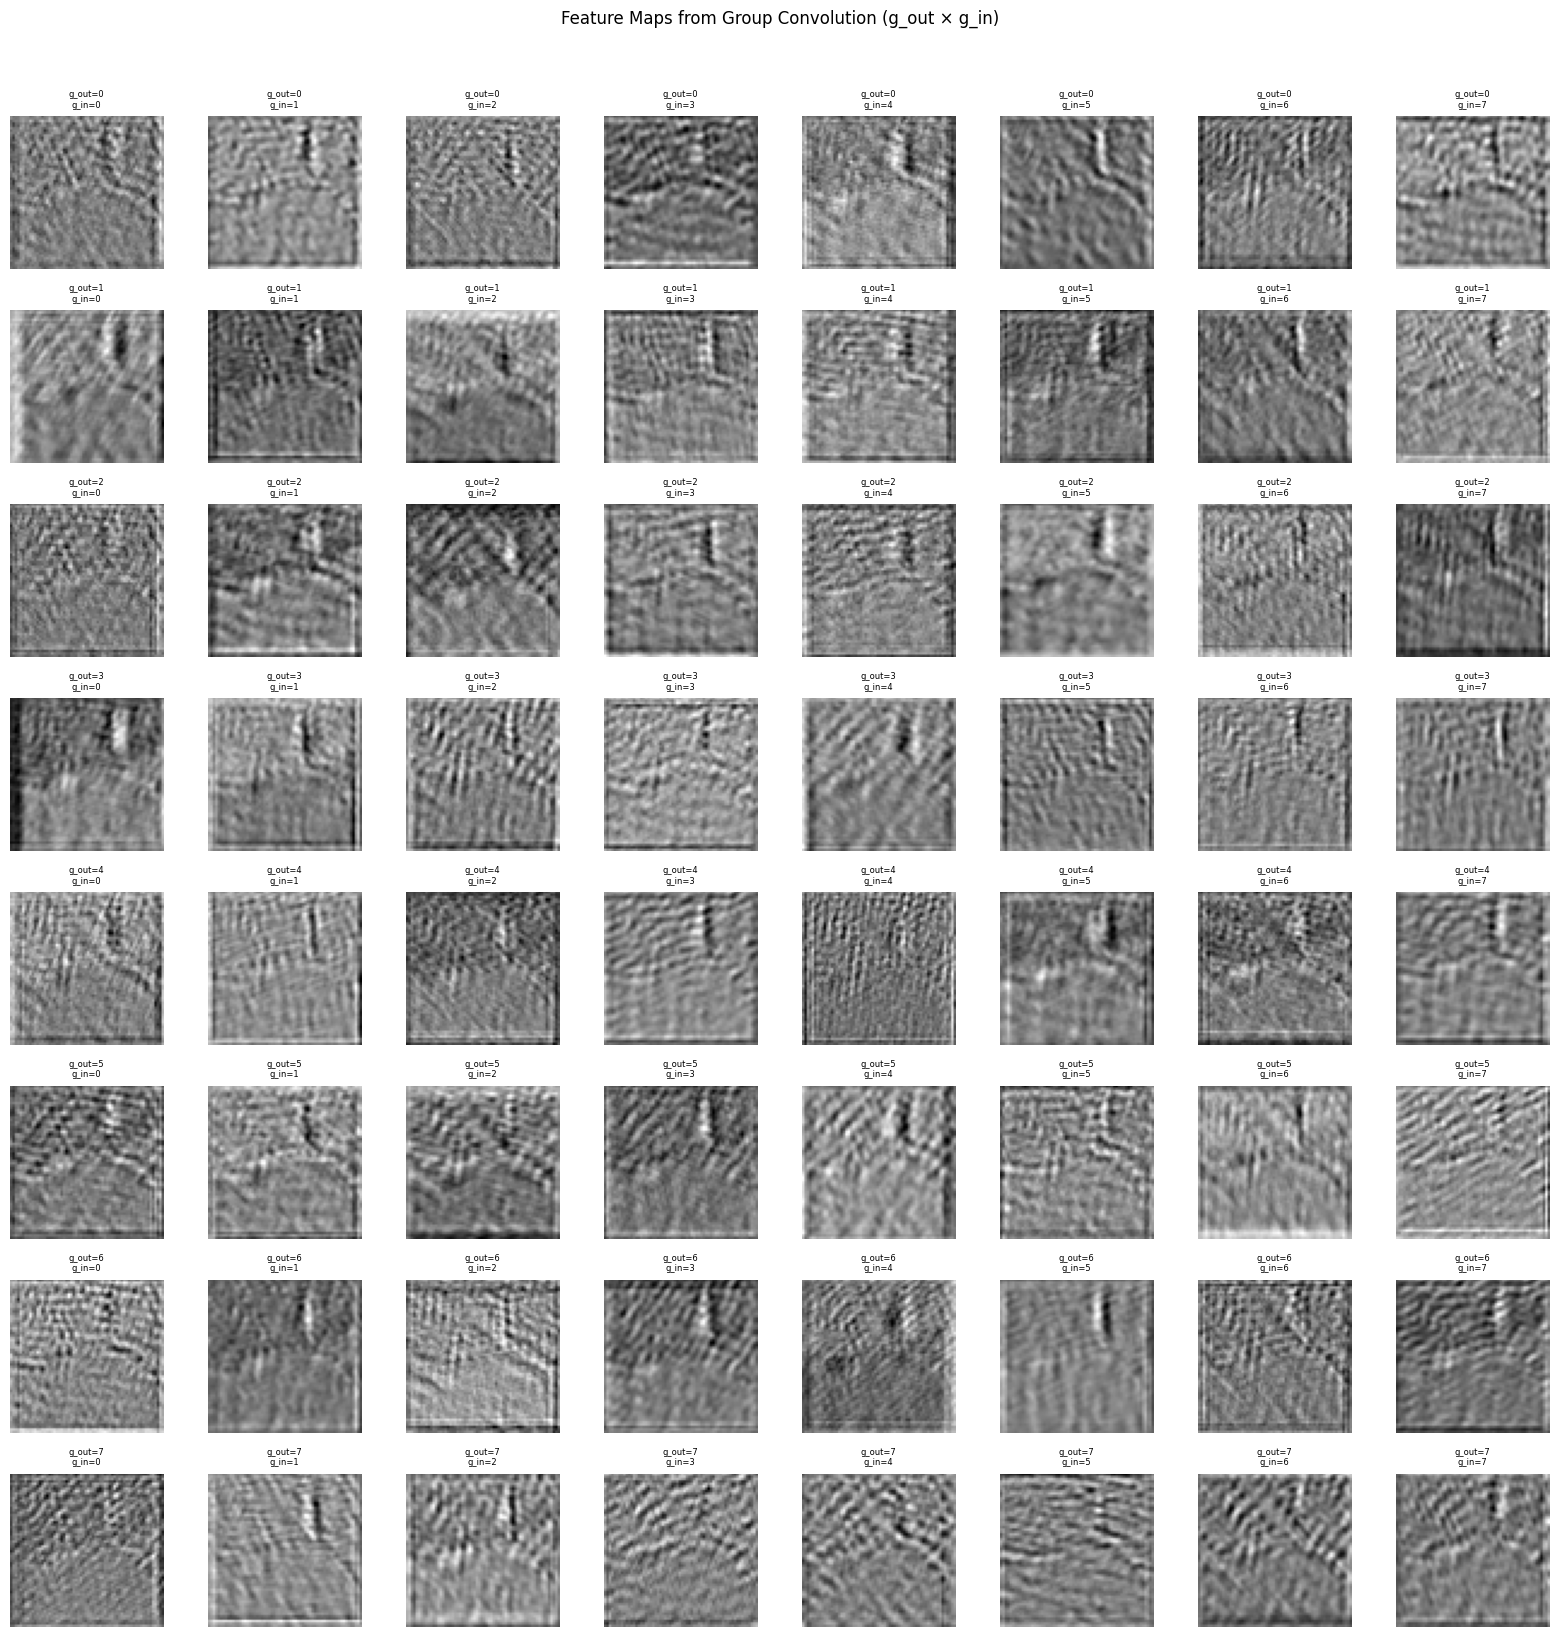

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np




class GroupConvolution(nn.Module):
    def __init__(self, group, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.group = group
        self.G = group.n_int
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.base_kernel = nn.Parameter(torch.randn(self.G, self.G, out_channels, in_channels, kernel_size, kernel_size))
        nn.init.kaiming_uniform_(self.base_kernel, a=np.sqrt(5))

    def forward(self, x):
        B, C_in, G_in, H, W = x.shape
        device = x.device
        group_elements = self.group.elements(device=device)
        output = torch.zeros(B, self.out_channels, self.G, H, W, device=device)

        for g_out_idx, g_out in enumerate(group_elements):
            for g_in_idx, g_in in enumerate(group_elements):
                h_rel = self.group.product(self.group.inverse(g_out), g_in)
                for oc in range(self.out_channels):
                    for ic in range(C_in):
                        base_k = self.base_kernel[g_out_idx, g_in_idx, oc, ic]
                        rot_k = rotate_kernel(base_k, self.group, h_rel).unsqueeze(0).unsqueeze(0)
                        x_in = x[:, ic, g_in_idx].unsqueeze(1)
                        conv_out = F.conv2d(x_in, rot_k, padding=self.padding)
                        output[:, oc, g_out_idx] += conv_out.squeeze(1)
        return output


img_path = "/workspaces/G-CNN-P5/cancer.png"  
image = Image.open(img_path).convert('L')
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
])
x = transform(image).unsqueeze(0).to(device) 


group = CyclicGroup(order=8)
lifting = LiftingConvolution(group, in_channels=1, out_channels=1, kernel_size=7, padding=3).to(device)
group_conv = GroupConvolution(group, in_channels=1, out_channels=1, kernel_size=7, padding=3).to(device)


lifting.eval()
group_conv.eval()
with torch.no_grad():
    lifted = lifting(x) 
G = group.n_int

lifting_maps = lifted[0, 0].detach().cpu()  
lifting_maps = (lifting_maps - lifting_maps.min()) / (lifting_maps.max() - lifting_maps.min() + 1e-8)

plt.figure(figsize=(12, 2))
for g in range(G):
    plt.subplot(1, G, g + 1)
    plt.imshow(lifting_maps[g].numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'g = {g}', fontsize=8)
plt.suptitle('Lifting Feature Maps (1 channel × 8 group elements)', y=1.05)
plt.tight_layout()
plt.show()



B, C_in, G_in, H, W = lifted.shape

feature_maps = torch.zeros(G, G, H, W, device=device)

group_elements = group.elements(device=device)
for g_out_idx, g_out in enumerate(group_elements):
    for g_in_idx, g_in in enumerate(group_elements):
        h_rel = group.product(group.inverse(g_out), g_in)
        base_k = group_conv.base_kernel[g_out_idx, g_in_idx, 0, 0]
        rot_k = rotate_kernel(base_k, group, h_rel).unsqueeze(0).unsqueeze(0)
        x_in = lifted[0, 0, g_in_idx].unsqueeze(0).unsqueeze(0)
        conv_out = F.conv2d(x_in, rot_k, padding=group_conv.padding)
        feature_maps[g_out_idx, g_in_idx] = conv_out.squeeze()
with torch.no_grad():

    B, C_in, G_in, H, W = lifted.shape
    G = group.n_int
    feature_maps = torch.zeros(G, G, H, W, device=device)

    group_elements = group.elements(device=device)
    for g_out_idx, g_out in enumerate(group_elements):
        for g_in_idx, g_in in enumerate(group_elements):
            h_rel = group.product(group.inverse(g_out), g_in)
            base_k = group_conv.base_kernel[g_out_idx, g_in_idx, 0, 0]
            rot_k = rotate_kernel(base_k, group, h_rel).unsqueeze(0).unsqueeze(0)
            x_in = lifted[0, 0, g_in_idx].unsqueeze(0).unsqueeze(0)
            conv_out = F.conv2d(x_in, rot_k, padding=group_conv.padding)
            feature_maps[g_out_idx, g_in_idx] = conv_out.squeeze()
    G = group.n_int  # <-- Add this line

    feature_maps = feature_maps.cpu()
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min() + 1e-8)

    plt.figure(figsize=(16, 16))
    for g_out in range(G):
        for g_in in range(G):
            idx = g_out * G + g_in + 1
            plt.subplot(G, G, idx)
            fmap = feature_maps[g_out, g_in].detach().numpy()
            plt.imshow(fmap, cmap='gray')
            plt.axis('off')
            plt.title(f'g_out={g_out}\ng_in={g_in}', fontsize=6)
    plt.suptitle('Feature Maps from Group Convolution (g_out × g_in)', y=1.02)
    plt.tight_layout()
    plt.show()




# Projected view

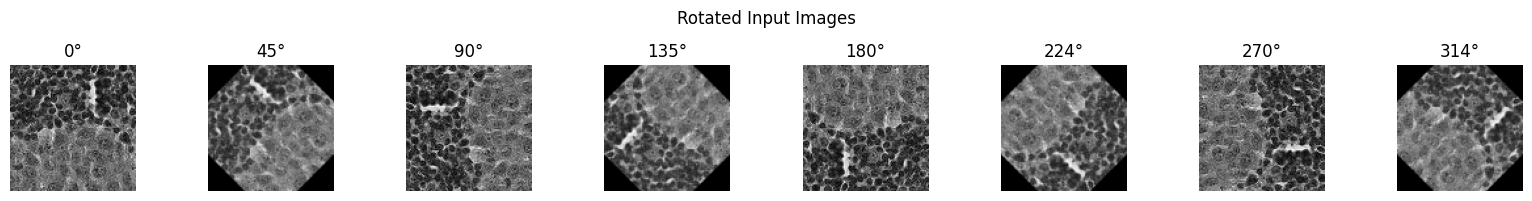

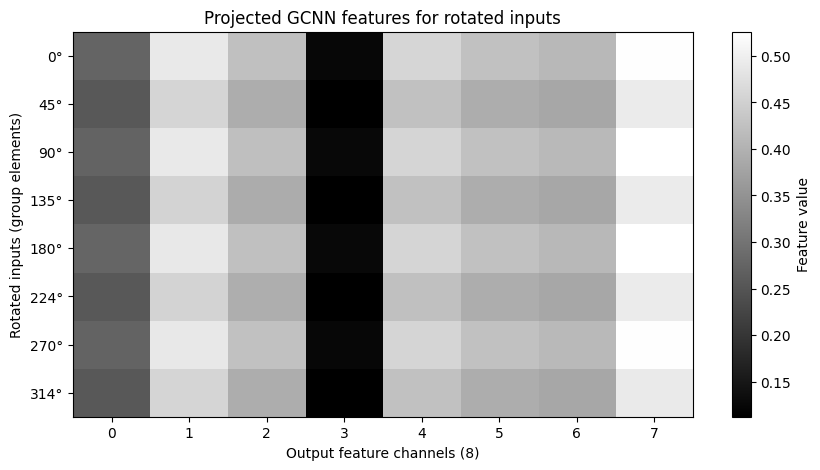

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img_path = "/workspaces/G-CNN-P5/cancer.png"
img = Image.open(img_path).convert('L')
img_tensor = TF.to_tensor(img).unsqueeze(0).to(device)  # (1, 1, H, W)


C8 = CyclicGroup(order=8)


lifting = LiftingConvolution(group=C8, in_channels=1, out_channels=4, kernel_size=5, padding=2).to(device)
gconv = GroupConvolution(group=C8, in_channels=4, out_channels=8, kernel_size=5, padding=2).to(device)

lifting.eval()
gconv.eval()


angles = C8.elements(device=device)
rotated_imgs = []
for angle_rad in angles:
    angle_deg = angle_rad.item() * 180 / np.pi
    rotated = TF.rotate(img_tensor[0], angle=angle_deg, interpolation=TF.InterpolationMode.BILINEAR)
    rotated_imgs.append(rotated.cpu())  # keep on CPU for matplotlib

rotated_batch = torch.stack(rotated_imgs).to(device) 


avgpool3d = torch.nn.AdaptiveAvgPool3d((1, 1, 1)).to(device)

with torch.no_grad():
    lifted = lifting(rotated_batch)       
    lifted = F.relu(F.layer_norm(lifted, lifted.shape[1:]))

    gconv_out = gconv(lifted)             
    gconv_out = F.relu(F.layer_norm(gconv_out, gconv_out.shape[1:]))

    pooled = avgpool3d(gconv_out)        
    projected = pooled.view(8, 8)        

fig, axs = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axs):
    ax.imshow(rotated_imgs[i][0], cmap='gray')  
    ax.axis('off')
    ax.set_title(f"{int(angles[i].item() * 180 / np.pi)}°")
plt.suptitle("Rotated Input Images")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.imshow(projected.cpu(), aspect='auto', cmap='gray')
plt.colorbar(label='Feature value')
plt.xlabel('Output feature channels (8)')
plt.ylabel('Rotated inputs (group elements)')
plt.title('Projected GCNN features for rotated inputs')
plt.yticks(
    ticks=range(8),
    labels=[f"{int(angle.item() * 180 / np.pi)}°" for angle in angles]
)
plt.show()
